# BN Generation Parameter Sweep

This notebook sweeps over DAG/BN generation parameters outlined in `notebooks/graph_generation/ideas.md` and materializes multiple discrete BN variants per DAG.

It varies:
- n (number of variables)
- target treewidth
- variable arity (fixed or range)
- CPT skewness (Dirichlet alpha)
- determinism fraction (mostly 0%)

Outputs:
- CSV with per-variant metadata
- On-screen CPT previews for a small sample



In [1]:
import sys
from pathlib import Path
import re
from os import getenv

# Ensure src is importable
repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))

from graph_generation import generate_dag_with_treewidth
from bn_generation import generate_variants_for_dag
from cpd_utils import cpd_to_ascii_table
from discrete.discrete_inference import format_probability_query, query_probability
from llm_calling import run_llm_call
from yaml_utils import load_yaml

import pandas as pd
import numpy as np
from openai import OpenAI

# Import query complexity functions and BN generation function from bn_query_sweep module
from bn_query_sweep import compute_query_complexity, compute_all_query_complexities, generate_bayesian_networks_and_metadata


In [25]:
# LLM Configuration and Helper Functions
# GLOBAL TOGGLE: Set to False to disable all LLM calls
ENABLE_LLM_CALLS = False

MODEL = "openai/gpt-5"
MODEL = "deepseek/deepseek-chat-v3.1:free"
MODEL = "openai/o3-mini-high"  

# Initialize OpenAI client (only if LLM calls are enabled)
if ENABLE_LLM_CALLS:
    client = OpenAI(
        base_url="https://openrouter.ai/api/v1",
        api_key=getenv("OPENROUTER_API_KEY")
    )
else:
    client = None
    print("LLM calls are DISABLED. Set ENABLE_LLM_CALLS = True to enable.")

# Load prompts
prompt_path = repo_root / "notebooks" / "discrete" / "prompts.yaml"
prompts = load_yaml(prompt_path)
# Import the functions from llm_calling instead of defining them here
from llm_calling import extract_numeric_answer, create_probability_prompt, run_llm_call 


LLM calls are DISABLED. Set ENABLE_LLM_CALLS = True to enable.


In [26]:
# Parameter grids (edit as needed)
#ns = [7, 11, 15]
#ns = [25]
ns = [8]
#treewidths = [2, 3, 4]
#treewidths = [5]
treewidths = [4, 5]
arity_specs = [
    #{"type": "fixed", "fixed": 2},
    {"type": "range", "min": 2, "max": 3},
]
#dirichlet_alphas = [0.5, 1.0]
dirichlet_alphas = [1.0, 0.5]
#determinism_fracs = [0.0, 0.1]  # mostly 0%; includes a nonzero test
determinism_fracs = [0.0]  # mostly 0%; includes a nonzero test
#naming_strategies = ['simple', 'confusing', 'semantic']  # Add naming strategy variation
#naming_strategies = ['simple', 'confusing']  # Add naming strategy variation
naming_strategies = ['confusing']  # Add naming strategy variation
variants_per_combo = 4
base_seed = 42

rows = []
preview_samples = []

sample_counter = 0
all_bayesian_networks = []  # Store all BNs and their metadata

In [27]:
# Generate Bayesian networks and populate metadata using the centralized function
all_bayesian_networks, rows, preview_samples = generate_bayesian_networks_and_metadata(
    ns=ns,
    treewidths=treewidths,
    arity_specs=arity_specs,
    dirichlet_alphas=dirichlet_alphas,
    determinism_fracs=determinism_fracs,
    naming_strategies=naming_strategies,
    variants_per_combo=variants_per_combo,
    base_seed=base_seed,
    max_preview_samples=3
)

print(f"Generated {len(all_bayesian_networks)} Bayesian networks")
print(f"Created {len(rows)} metadata rows")
print(f"Collected {len(preview_samples)} preview samples")

df = pd.DataFrame(rows)
display(df.head())
print(f"Total variants: {len(df)}")
out_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep.csv'

Generated 16 Bayesian networks
Created 16 metadata rows
Collected 12 preview samples


,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes
0,8,4,4,confusing,range:2-3,1.0,0.0,42,0,14,8
1,8,4,4,confusing,range:2-3,1.0,0.0,10015,1,14,8
2,8,4,4,confusing,range:2-3,1.0,0.0,19988,2,14,8
3,8,4,4,confusing,range:2-3,1.0,0.0,29961,3,14,8
4,8,4,4,confusing,range:2-3,0.5,0.0,43,0,14,8


Total variants: 16


In [28]:
# Filter out BNs where the number of edges is less than twice the number of nodes
def num_edges(bn):
    # For pgmpy BayesianModel, the edges can be accessed by .edges
    return len(list(bn.edges()))

filtered_bn_list = []
filtered_rows = []

# Map original BN indices to their indices in the filtered list
original_bn_idx_to_filtered_idx = {}

for orig_idx, (bn_dict, row) in enumerate(zip(all_bayesian_networks, rows)):
    bn = bn_dict["bn"]
    n_nodes = len(bn.nodes())
    n_edges = num_edges(bn)
    if n_edges >= 2 * n_nodes:
        filtered_bn_list.append(bn_dict)
        filtered_rows.append(row)
        original_bn_idx_to_filtered_idx[orig_idx] = len(filtered_bn_list) - 1


# Overwrite the master lists with the filtered ones
all_bayesian_networks = filtered_bn_list
rows = filtered_rows

print(f"After filtering, {len(all_bayesian_networks)} Bayesian networks remain.")


After filtering, 8 Bayesian networks remain.


In [29]:
df = pd.DataFrame(rows)
display(df.head())
print(f"Total variants: {len(df)}")

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes
0,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,8
1,8,5,5,confusing,range:2-3,1.0,0.0,10017,1,17,8
2,8,5,5,confusing,range:2-3,1.0,0.0,19990,2,17,8
3,8,5,5,confusing,range:2-3,1.0,0.0,29963,3,17,8
4,8,5,5,confusing,range:2-3,0.5,0.0,45,0,17,8


Total variants: 8


In [40]:
# For each Bayesian network, generate n queries using generate_queries, run them, and collect results
from query_generation import generate_queries
from pgmpy.inference import VariableElimination

# Store all queries for later recovery: a list of lists (per BN)
all_bn_queries = []

query_rows = []

def count_unobserved_ancestors_and_neighbours(bn, target_nodes, evidence_nodes):
    """
    For the given Bayesian network, return both:
     - the number of unique ancestors of the target_nodes that are not in evidence_nodes
     - the number of unique neighbors (parents or children, i.e., Markov blanket without evidence or target nodes)
    Returns (num_unobserved_ancestors, num_unobserved_neighbours), and the sets themselves.
    """
    all_ancestors = set()
    for v in target_nodes:
        # Recursively collect ancestors using get_parents
        def get_ancestors(node, bn, visited=None):
            if visited is None:
                visited = set()
            parents = set(bn.get_parents(node))
            new_parents = parents - visited
            visited.update(new_parents)
            for p in new_parents:
                get_ancestors(p, bn, visited)
            return visited
        all_ancestors.update(get_ancestors(v, bn))
    unobs_ancestors = all_ancestors - set(evidence_nodes)

    all_neighbours = set()
    for v in target_nodes:
        # Get parents and children for neighbours
        parents = set(bn.get_parents(v))
        children = set(bn.get_children(v))
        all_neighbours.update(parents)
        all_neighbours.update(children)
    # Remove target and evidence nodes
    unobs_neighbours = all_neighbours - set(target_nodes) - set(evidence_nodes)

    return len(unobs_ancestors), len(unobs_neighbours), unobs_ancestors, unobs_neighbours

for idx, bn_dict in enumerate(all_bayesian_networks):
    bn = bn_dict["bn"]
    # Use a different seed per BN for query generation for reproducibility
    query_seed = 1000 + idx
    # Generate queries for this BN
    queries = generate_queries(
        bn,
        num_queries=24,
        query_node_counts=(1, 2),
        #query_node_counts=[2],
        evidence_counts=(0, 1, 2),
        #evidence_counts=(2),
        #distance_buckets=[(1, 1), (2, 3), (1, 3)],
        distance_buckets=[(2, 3)],
        seed=query_seed,
    )
    all_bn_queries.append(queries)
    # Get the BN's properties from the main df
    bn_row = df.iloc[idx].to_dict()
    for qidx, query in enumerate(queries):
        # Prepare inference
        infer = VariableElimination(bn)
        # Query variables and their states
        query_vars = [v for v, _ in query.targets]
        query_states = [s for _, s in query.targets]
        # Evidence dict: variable -> state
        evidence = query.evidence if query.evidence else None
        evidence_nodes = list(query.evidence.keys()) if query.evidence else []

        # Count number of ancestors of target nodes that are not observed (not in evidence)
        num_unobserved_ancestors, num_unobserved_neighbours, unobserved_ancestors, unobserved_neighbours = count_unobserved_ancestors_and_neighbours(bn, query_vars, evidence_nodes)

        # Compute exact probability (with evidence)
        try:
            result = infer.query(variables=query_vars, evidence=evidence, show_progress=False)
            assignment = dict(zip(query_vars, query_states))
            prob = result.get_value(**assignment)
        except Exception as e:
            prob = None

        # Compute prior probability (no evidence)
        try:
            prior_result = infer.query(variables=query_vars, evidence=None, show_progress=False)
            prior_assignment = dict(zip(query_vars, query_states))
            prior_prob = prior_result.get_value(**prior_assignment)
        except Exception as e:
            prior_prob = None

        # Collect all info for the table, merging BN and query properties (no LLM here)
        row = dict(bn_row)  # copy BN properties
        row.update({
            "bn_index": idx,
            "query_index": qidx,
            "query_vars": str(query_vars),
            "query_states": str(query_states),
            "evidence": str(query.evidence),
            "distance": query.meta.get("min_target_evidence_distance"),
            "num_evidence": query.meta.get("num_evidence_nodes"),
            "probability": prob,
            "prior_probability": prior_prob,  # add the prior probability as a new column
            "num_unobserved_ancestors": num_unobserved_ancestors,  # new column per instructions
            "num_unobserved_neighbours": num_unobserved_neighbours,
        })
        query_rows.append(row)

# Convert to DataFrame and display
full_df = pd.DataFrame(query_rows)
print(f"Total queries: {len(full_df)}")

Total queries: 192


In [41]:
full_df

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,...,query_index,query_vars,query_states,evidence,distance,num_evidence,probability,prior_probability,num_unobserved_ancestors,num_unobserved_neighbours
0,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,0,[np.str_('K_5si3ik')],['s2'],{np.str_('X_wzdhd9'): 's1'},2,1,0.153647,0.313433,2,4
1,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,1,[np.str_('X_wzdhd9')],['s1'],{},0,0,0.061809,0.061809,0,5
2,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,2,[np.str_('K_gvnrp2')],['s0'],{},0,0,0.559606,0.559606,5,5
3,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,3,[np.str_('I_rk69zv')],['s1'],"{np.str_('K_5si3ik'): 's0', np.str_('M_clcji8'...",2,2,0.568868,0.547319,4,3
4,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,4,[np.str_('U_9d6udx')],['s2'],{np.str_('G_bo3vt6'): 's0'},2,1,0.351413,0.351413,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,8,5,5,confusing,range:2-3,0.5,0.0,29964,3,17,...,19,"[np.str_('W_qis23b'), np.str_('K_5si3ik')]","['s1', 's2']",{},0,0,0.183660,0.183660,4,6
188,8,5,5,confusing,range:2-3,0.5,0.0,29964,3,17,...,20,"[np.str_('K_gvnrp2'), np.str_('M_clcji8')]","['s1', 's0']",{},0,0,0.323724,0.323724,5,5
189,8,5,5,confusing,range:2-3,0.5,0.0,29964,3,17,...,21,[np.str_('M_clcji8')],['s0'],{np.str_('K_gvnrp2'): 's1'},2,1,0.834225,0.489755,5,4
190,8,5,5,confusing,range:2-3,0.5,0.0,29964,3,17,...,22,"[np.str_('W_qis23b'), np.str_('M_clcji8')]","['s0', 's0']",{np.str_('I_rk69zv'): 's1'},1,1,0.087033,0.389210,5,5


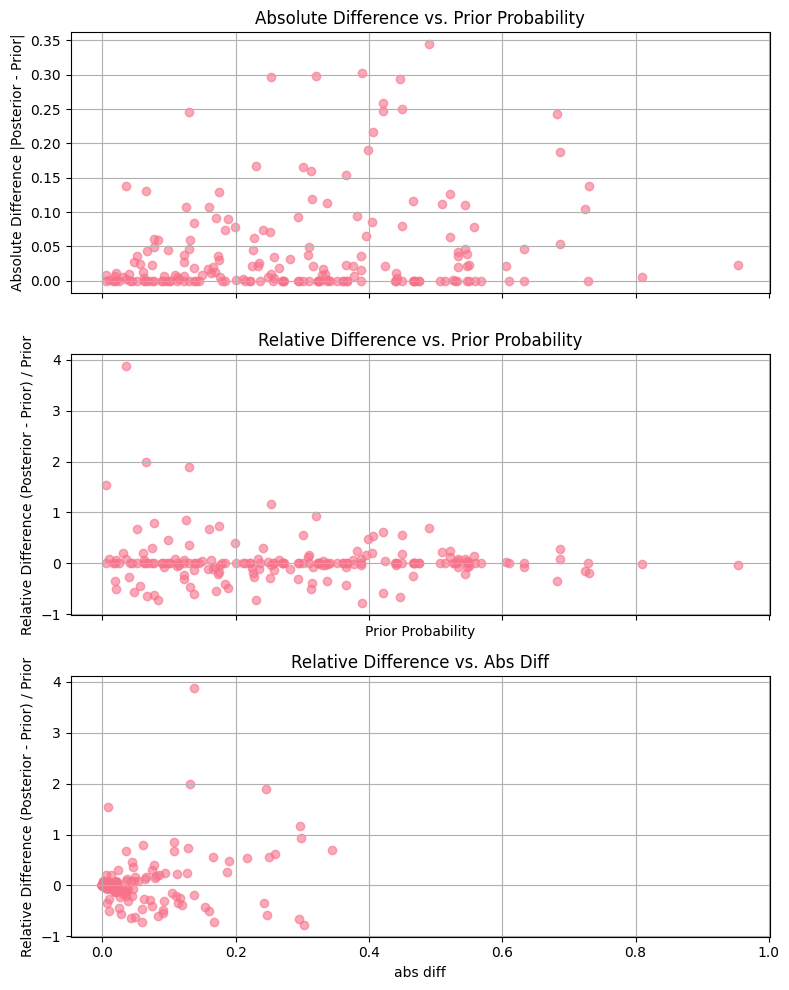

In [42]:
import matplotlib.pyplot as plt
import numpy as np

prior = full_df["prior_probability"].astype(float)
posterior = full_df["probability"].astype(float)

# Mask out rows where prior or posterior is NaN
mask = ~(prior.isna() | posterior.isna())
prior = prior[mask]
posterior = posterior[mask]

abs_diff = np.abs(posterior - prior)
# Avoid division by zero; mask entries where prior=0 for rel_diff
with np.errstate(divide='ignore', invalid='ignore'):
    rel_diff = np.where(prior != 0, (posterior - prior) / prior, np.nan)

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Absolute difference plot
axs[0].scatter(prior, abs_diff, alpha=0.6)
axs[0].set_ylabel("Absolute Difference |Posterior - Prior|")
axs[0].set_title("Absolute Difference vs. Prior Probability")
axs[0].grid(True)

# Relative difference plot
axs[1].scatter(prior, rel_diff, alpha=0.6)
axs[1].set_xlabel("Prior Probability")
axs[1].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[1].set_title("Relative Difference vs. Prior Probability")
axs[1].grid(True)


axs[2].scatter(abs_diff, rel_diff, alpha=0.6)
axs[2].set_xlabel("abs diff")
axs[2].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[2].set_title("Relative Difference vs. Abs Diff")
axs[2].grid(True)


plt.tight_layout()
plt.show()


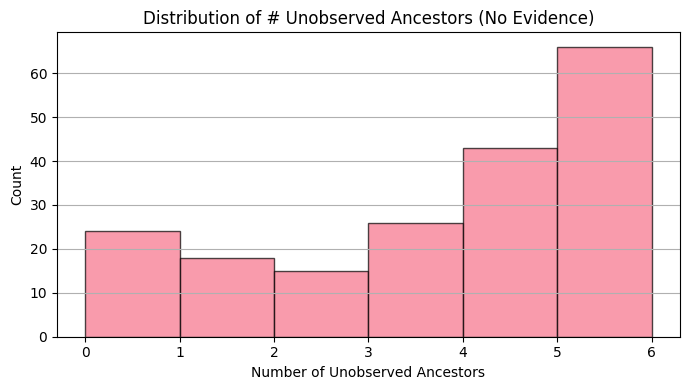

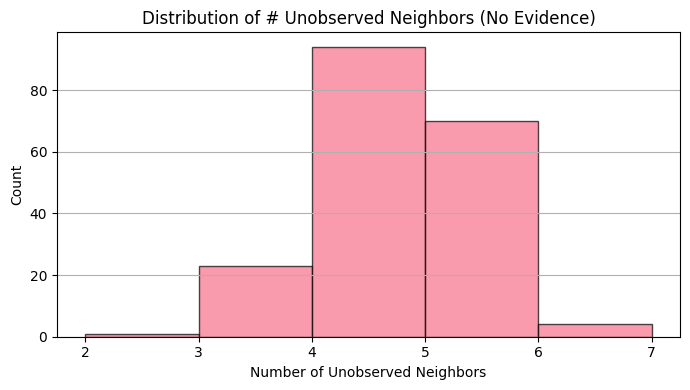

In [44]:
# Plot distribution of number of unobserved ancestors
unobs_anc_counts = full_df["num_unobserved_ancestors"]

plt.figure(figsize=(7, 4))
plt.hist(unobs_anc_counts, bins=range(int(unobs_anc_counts.min()), int(unobs_anc_counts.max())+2), edgecolor="black", alpha=0.7)
plt.title("Distribution of # Unobserved Ancestors (No Evidence)")
plt.xlabel("Number of Unobserved Ancestors")
plt.ylabel("Count")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Plot distribution of number of unobserved neighbors
if "num_unobserved_neighbours" in full_df.columns:
    unobs_neigh_counts = full_df["num_unobserved_neighbours"]
    plt.figure(figsize=(7, 4))
    plt.hist(unobs_neigh_counts, bins=range(int(unobs_neigh_counts.min()), int(unobs_neigh_counts.max())+2), edgecolor="black", alpha=0.7)
    plt.title("Distribution of # Unobserved Neighbors (No Evidence)")
    plt.xlabel("Number of Unobserved Neighbors")
    plt.ylabel("Count")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'num_unobserved_neighbors' not found in full_df.")

In [45]:
    # Keep only queries where absolute value of relative difference > 0.5 and absolute difference > 0.1
# Store them for further analysis
full_df = full_df.copy()
full_df["abs_diff"] = abs_diff
full_df["rel_diff"] = rel_diff

full_df = full_df[(full_df["rel_diff"].abs() > 0.5) & (full_df["abs_diff"] > 0.1)].reset_index(drop=True)

# Keep only queries with at least 3 unobserved ancestors
#full_df = full_df[full_df["num_unobserved_ancestors"] >= 2].reset_index(drop=True)

In [46]:
full_df

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,...,query_states,evidence,distance,num_evidence,probability,prior_probability,num_unobserved_ancestors,num_unobserved_neighbours,abs_diff,rel_diff
0,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,['s2'],{np.str_('X_wzdhd9'): 's1'},2,1,0.153647,0.313433,2,4,0.159785,-0.509791
1,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,['s1'],"{np.str_('X_wzdhd9'): 's1', np.str_('I_rk69zv'...",2,2,0.618681,0.321214,2,4,0.297468,0.926074
2,8,5,5,confusing,range:2-3,1.0,0.0,10017,1,17,...,"['s1', 's2']",{np.str_('K_5si3ik'): 's1'},1,1,0.197094,0.065835,3,4,0.131259,1.993752
3,8,5,5,confusing,range:2-3,1.0,0.0,19990,2,17,...,"['s1', 's1']","{np.str_('K_5si3ik'): 's1', np.str_('K_gvnrp2'...",1,2,0.303579,0.174456,4,4,0.129124,0.740153
4,8,5,5,confusing,range:2-3,0.5,0.0,10018,1,17,...,['s2'],{np.str_('W_qis23b'): 's0'},2,1,0.467520,0.301339,0,4,0.166181,0.551477
5,8,5,5,confusing,range:2-3,0.5,0.0,19991,2,17,...,"['s1', 's1']",{np.str_('U_9d6udx'): 's0'},1,1,0.376167,0.130325,3,5,0.245842,1.886377
6,8,5,5,confusing,range:2-3,0.5,0.0,19991,2,17,...,"['s0', 's0']",{np.str_('G_bo3vt6'): 's2'},1,1,0.268011,0.160245,3,4,0.107766,0.672508
7,8,5,5,confusing,range:2-3,0.5,0.0,19991,2,17,...,['s0'],"{np.str_('I_rk69zv'): 's1', np.str_('X_wzdhd9'...",2,2,0.622780,0.406285,2,4,0.216495,0.532866
8,8,5,5,confusing,range:2-3,0.5,0.0,19991,2,17,...,"['s1', 's0']","{np.str_('G_bo3vt6'): 's0', np.str_('M_clcji8'...",1,2,0.550313,0.253581,3,4,0.296732,1.170165
9,8,5,5,confusing,range:2-3,0.5,0.0,19991,2,17,...,['s1'],"{np.str_('I_rk69zv'): 's0', np.str_('M_clcji8'...",2,2,0.700554,0.449753,5,5,0.250800,0.557640


In [47]:
# Choose a row index from full_df to analyze
test_row_index = 0  # Change this to any valid row index

print("=" * 80)
print(f"TESTING QUERY-SPECIFIC COMPLEXITY COMPUTATION FOR ROW {test_row_index}")
print("=" * 80)

# Compute complexity for the selected row
complexity_result = compute_query_complexity(full_df, all_bayesian_networks, test_row_index, verbose=True)

print("\n" + "=" * 80)
print("DETAILED COMPLEXITY METRICS:")
print("=" * 80)

# Display the results in a nice format
for key, value in complexity_result.items():
    if key not in ['elimination_order', 'complete_elimination_order', 'factor_sizes', 'query_vars', 'query_states', 'evidence', 'keep_vars', 'eliminate_vars']:
        print(f"{key:25}: {value}")
    elif key in ['elimination_order', 'complete_elimination_order']:
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    elif key == 'factor_sizes':
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    else:
        print(f"{key:25}: {value}")

print("\n" + "=" * 80)
print("FACTOR SIZE PROGRESSION:")
print("=" * 80)
for i, size in enumerate(complexity_result['factor_sizes']):
    print(f"Step {i+1:2d}: {size:8,} entries")

print("\n" + "=" * 80)
print("QUERY-SPECIFIC ANALYSIS:")
print("=" * 80)
print(f"Query variables kept: {complexity_result['keep_vars']}")
print(f"Variables eliminated: {complexity_result['eliminate_vars']}")
print(f"Variables eliminated: {complexity_result['num_eliminated_vars']}/{complexity_result['num_vars']} ({complexity_result['num_eliminated_vars']/complexity_result['num_vars']*100:.1f}%)")


TESTING QUERY-SPECIFIC COMPLEXITY COMPUTATION FOR ROW 0
Computing complexity for query: P(['K_5si3ik']=['s2'] | {'X_wzdhd9': 's1'})
BN: 0, Query: 0
Variable cardinalities: defaultdict(<class 'int'>, {'X_wzdhd9': np.int64(3), 'U_9d6udx': np.int64(3), 'G_bo3vt6': np.int64(2), 'K_5si3ik': np.int64(3), 'W_qis23b': np.int64(3), 'I_rk69zv': np.int64(2), 'M_clcji8': np.int64(2), 'K_gvnrp2': np.int64(2)})
Variables to keep (query): ['K_5si3ik']
Variables to eliminate: ['G_bo3vt6', 'I_rk69zv', 'K_gvnrp2', 'M_clcji8', 'U_9d6udx', 'W_qis23b', 'X_wzdhd9']
Evidence variables: ['X_wzdhd9']
Effective cardinalities (after evidence): {'X_wzdhd9': 1, 'U_9d6udx': np.int64(3), 'G_bo3vt6': np.int64(2), 'K_5si3ik': np.int64(3), 'W_qis23b': np.int64(3), 'I_rk69zv': np.int64(2), 'M_clcji8': np.int64(2), 'K_gvnrp2': np.int64(2)}


  0%|          | 0/7 [00:00<?, ?it/s]

Elimination order (variables to eliminate): ['I_rk69zv', 'M_clcji8', 'U_9d6udx', 'X_wzdhd9', 'W_qis23b', 'G_bo3vt6', 'K_gvnrp2']
Complete elimination order: ['I_rk69zv', 'M_clcji8', 'U_9d6udx', 'X_wzdhd9', 'W_qis23b', 'G_bo3vt6', 'K_gvnrp2', 'K_5si3ik']
Induced width: 5
Step 1: Eliminating I_rk69zv, neighbors: ['W_qis23b', 'X_wzdhd9', 'U_9d6udx'], factor size: 18
Step 2: Eliminating M_clcji8, neighbors: ['W_qis23b', 'X_wzdhd9', 'G_bo3vt6', 'U_9d6udx'], factor size: 36
Step 3: Eliminating U_9d6udx, neighbors: ['W_qis23b', 'K_gvnrp2', 'X_wzdhd9', 'G_bo3vt6', 'K_5si3ik'], factor size: 108
Step 4: Eliminating X_wzdhd9, neighbors: ['W_qis23b', 'K_gvnrp2', 'G_bo3vt6', 'K_5si3ik'], factor size: 36
Step 5: Eliminating W_qis23b, neighbors: ['K_gvnrp2', 'K_5si3ik', 'G_bo3vt6'], factor size: 36
Step 6: Eliminating G_bo3vt6, neighbors: ['K_gvnrp2', 'K_5si3ik'], factor size: 12
Step 7: Eliminating K_gvnrp2, neighbors: ['K_5si3ik'], factor size: 6
Final factor (query variables): ['K_5si3ik'], size: 

In [48]:
complexity_df = compute_all_query_complexities(full_df, all_bayesian_networks, verbose=True)
print("\nComplexity DataFrame:")
display(complexity_df.head())

Processing query 1/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 2/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 3/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 4/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 5/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 6/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 7/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 8/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 9/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 10/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 11/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 12/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 13/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 14/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 15/18...


  0%|          | 0/6 [00:00<?, ?it/s]

Processing query 16/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 17/18...


  0%|          | 0/7 [00:00<?, ?it/s]

Processing query 18/18...


  0%|          | 0/6 [00:00<?, ?it/s]


Computed complexity for 18 queries
Successful computations: 18
Failed computations: 0

Complexity DataFrame:


,row_index,bn_index,query_index,query_vars,query_states,evidence,num_vars,num_edges,num_query_vars,num_evidence_vars,...,complete_elimination_order,induced_width,total_cost,max_factor_size,avg_factor_size,factor_sizes,log_total_cost,log_max_factor_size,keep_vars,eliminate_vars
0,0,0,0,[K_5si3ik],[s2],{'X_wzdhd9': 's1'},8,17,1,1,...,"[I_rk69zv, M_clcji8, U_9d6udx, X_wzdhd9, W_qis...",5,255,108,36.428571,"[18, 36, 108, 36, 36, 12, 6]",7.994353,6.754888,[K_5si3ik],"[G_bo3vt6, I_rk69zv, K_gvnrp2, M_clcji8, U_9d6..."
1,1,0,10,[K_5si3ik],[s1],"{'X_wzdhd9': 's1', 'I_rk69zv': 's1'}",8,17,1,2,...,"[I_rk69zv, M_clcji8, U_9d6udx, X_wzdhd9, W_qis...",5,246,108,35.142857,"[9, 36, 108, 36, 36, 12, 6]",7.942515,6.754888,[K_5si3ik],"[G_bo3vt6, I_rk69zv, K_gvnrp2, M_clcji8, U_9d6..."
2,2,1,7,"[W_qis23b, X_wzdhd9]","[s1, s2]",{'K_5si3ik': 's1'},8,17,2,1,...,"[I_rk69zv, M_clcji8, U_9d6udx, G_bo3vt6, K_gvn...",5,423,162,70.500000,"[81, 162, 108, 36, 18, 9]",8.724514,7.339850,"[W_qis23b, X_wzdhd9]","[G_bo3vt6, I_rk69zv, K_5si3ik, K_gvnrp2, M_clc..."
3,3,2,8,"[W_qis23b, M_clcji8]","[s1, s1]","{'K_5si3ik': 's1', 'K_gvnrp2': 's1'}",8,17,2,2,...,"[I_rk69zv, K_gvnrp2, K_5si3ik, U_9d6udx, G_bo3...",5,198,72,33.000000,"[36, 24, 24, 72, 24, 12]",7.629357,6.169925,"[M_clcji8, W_qis23b]","[G_bo3vt6, I_rk69zv, K_5si3ik, K_gvnrp2, U_9d6..."
4,4,5,16,[U_9d6udx],[s2],{'W_qis23b': 's0'},8,17,1,1,...,"[I_rk69zv, M_clcji8, X_wzdhd9, W_qis23b, K_5si...",5,255,108,36.428571,"[18, 36, 108, 36, 36, 12, 6]",7.994353,6.754888,[U_9d6udx],"[G_bo3vt6, I_rk69zv, K_5si3ik, K_gvnrp2, M_clc..."


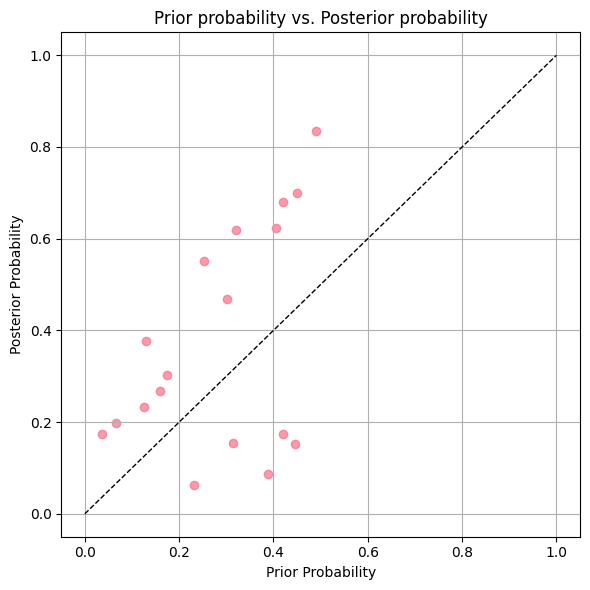

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(full_df["prior_probability"], full_df["probability"], alpha=0.7)
plt.xlabel("Prior Probability")
plt.ylabel("Posterior Probability")
plt.title("Prior probability vs. Posterior probability")
plt.plot([0, 1], [0, 1], 'k--', lw=1)  # Line y=x for reference
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# Inspect a single row: draw BN, call LLM, compare\n
from bn_query_sweep import inspect_row_and_call_llm, call_llm_for_query
from pathlib import Path
#ENABLE_LLM_CALLS = True
if ENABLE_LLM_CALLS:
    # Choose a row index from full_df
    #row_index = 330
    row_index = 2

    result = inspect_row_and_call_llm(
        full_df=full_df,
        all_bayesian_networks=all_bayesian_networks,
        row_index=row_index,
        openai_client=client,
        model=MODEL,
        prompts_path=prompt_path,
        draw_kwargs={"figsize": (6, 4)},
    )
    print(result)

In [21]:
result


<DiscreteFactor representing phi(K_5si3ik:2, G_bo3vt6:3) at 0x7629ebb14fb0>

In [50]:
# Optional: Call LLM on a subset AFTER query generation
# Provide indices of rows in full_df for which to call the LLM.
# Import _parse_field from bn_query_sweep instead of defining it locally
from bn_query_sweep import _parse_field, call_llm_for_query

# Ensure LLM columns exist
if 'llm_probability' not in full_df.columns:
    full_df['llm_probability'] = None
if 'llm_response' not in full_df.columns:
    full_df['llm_response'] = None


ENABLE_LLM_CALLS = True
if ENABLE_LLM_CALLS:
    # Select which rows to send to LLM (example below commented out)
    #selected_indices = list(full_df.sample(n=40, random_state=0).index)
    selected_indices = list(full_df.sample(n=5, random_state=0).index)
    #selected_indices = list(full_df.index)

    for ridx in selected_indices:
        row = full_df.iloc[ridx]
        bn = all_bayesian_networks[int(row['bn_index'])]['bn']
        query_vars = _parse_field(row['query_vars']) or []
        query_states = _parse_field(row['query_states']) or []
        evidence = _parse_field(row['evidence']) or None
        print(f"Processing BN {int(row['bn_index'])}/{len(all_bayesian_networks)}, Query {int(row['query_index'])}...")
        llm_prob, llm_response = call_llm_for_query(bn, query_vars, query_states, evidence)
        full_df.at[ridx, 'llm_probability'] = llm_prob
        full_df.at[ridx, 'llm_response'] = llm_response
else:
    print("LLM calls are disabled. Skipping batch LLM processing.")
    print(f"Would have processed {len(full_df)} queries if LLM calls were enabled.")

ENABLE_LLM_CALLS = False

Processing BN 0/8, Query 10...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 6/8, Query 7...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 6/8, Query 17...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 7/8, Query 4...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 7/8, Query 14...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


In [51]:
import datetime
from pathlib import Path

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

# Drop BN and query identifier columns before saving (if present)
cols_to_drop = [col for col in ['bn_index', 'query_index'] if col in full_df.columns]
full_df_no_ids = full_df.drop(columns=cols_to_drop) if cols_to_drop else full_df

# Instead of relying on out_query_csv, construct the path directly
out_llm_csv = Path(f"llm_query_results_{timestamp}_with_llm.csv")
full_df_no_ids.to_csv(out_llm_csv, index=False)
print("Saved DataFrame with LLM responses to", out_llm_csv)


Saved DataFrame with LLM responses to llm_query_results_20251025_121459_with_llm.csv


In [52]:
# Print rows with non-empty llm_probability
llm_rows = full_df[full_df['llm_probability'].notna()]
print(f"Found {len(llm_rows)} rows with LLM probability values:")
print("=" * 80)
display(llm_rows)


Found 5 rows with LLM probability values:


,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,...,distance,num_evidence,probability,prior_probability,num_unobserved_ancestors,num_unobserved_neighbours,abs_diff,rel_diff,llm_probability,llm_response
1,8,5,5,confusing,range:2-3,1.0,0.0,44,0,17,...,2,2,0.618681,0.321214,2,4,0.297468,0.926074,0.5868,"Final Answer: P(K_5si3ik=s1 | X_wzdhd9=s1, I_r..."
6,8,5,5,confusing,range:2-3,0.5,0.0,19991,2,17,...,1,1,0.268011,0.160245,3,4,0.107766,0.672508,0.268,"Final Answer: P(X_wzdhd9=s0, W_qis23b=s0 | G_b..."
8,8,5,5,confusing,range:2-3,0.5,0.0,19991,2,17,...,1,2,0.550313,0.253581,3,4,0.296732,1.170165,0.56,"Final Answer: P(U_9d6udx=s1, W_qis23b=s0 | G_b..."
10,8,5,5,confusing,range:2-3,0.5,0.0,29964,3,17,...,1,1,0.173740,0.035636,2,4,0.138104,3.875454,0.1736,"Final Answer: P(K_5si3ik=s1, G_bo3vt6=s1 | U_9..."
14,8,5,5,confusing,range:2-3,0.5,0.0,29964,3,17,...,1,2,0.151843,0.446287,4,3,0.294444,-0.659764,0.6707,"Final Answer: P(G_bo3vt6=s0, K_gvnrp2=s0 | M_c..."


In [53]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

# Save enhanced results with LLM data
enhanced_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries_with_llm.csv'
full_df.to_csv(enhanced_csv, index=False)
print(f'Saved enhanced results with LLM data to {enhanced_csv}')

LLM Performance Analysis:
Successful LLM responses: 5/18 (27.8%)
Saved enhanced results with LLM data to /home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/notebooks/graph_generation/bn_generation_sweep_queries_with_llm.csv


In [54]:
# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        # Show some examples
        print(f"\nFirst 5 successful responses:")
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']].head())
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")


Accuracy Metrics (for 5 successful responses):
Mean Absolute Error: 0.112115
Mean Relative Error: 0.697411
Max Absolute Error: 0.518857
Max Relative Error: 3.417071

First 5 successful responses:


,query_vars,query_states,evidence,probability,llm_probability,abs_error
1,[np.str_('K_5si3ik')],['s1'],"{np.str_('X_wzdhd9'): 's1', np.str_('I_rk69zv'...",0.618681,0.5868,0.031881
6,"[np.str_('X_wzdhd9'), np.str_('W_qis23b')]","['s0', 's0']",{np.str_('G_bo3vt6'): 's2'},0.268011,0.268,0.000011
8,"[np.str_('U_9d6udx'), np.str_('W_qis23b')]","['s1', 's0']","{np.str_('G_bo3vt6'): 's0', np.str_('M_clcji8'...",0.550313,0.56,0.009687
10,"[np.str_('K_5si3ik'), np.str_('G_bo3vt6')]","['s1', 's1']",{np.str_('U_9d6udx'): 's1'},0.173740,0.1736,0.00014
14,"[np.str_('G_bo3vt6'), np.str_('K_gvnrp2')]","['s0', 's0']","{np.str_('M_clcji8'): 's0', np.str_('W_qis23b'...",0.151843,0.6707,0.518857


/tmp/ipykernel_38605/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_38605/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_38605/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_38605/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_38605

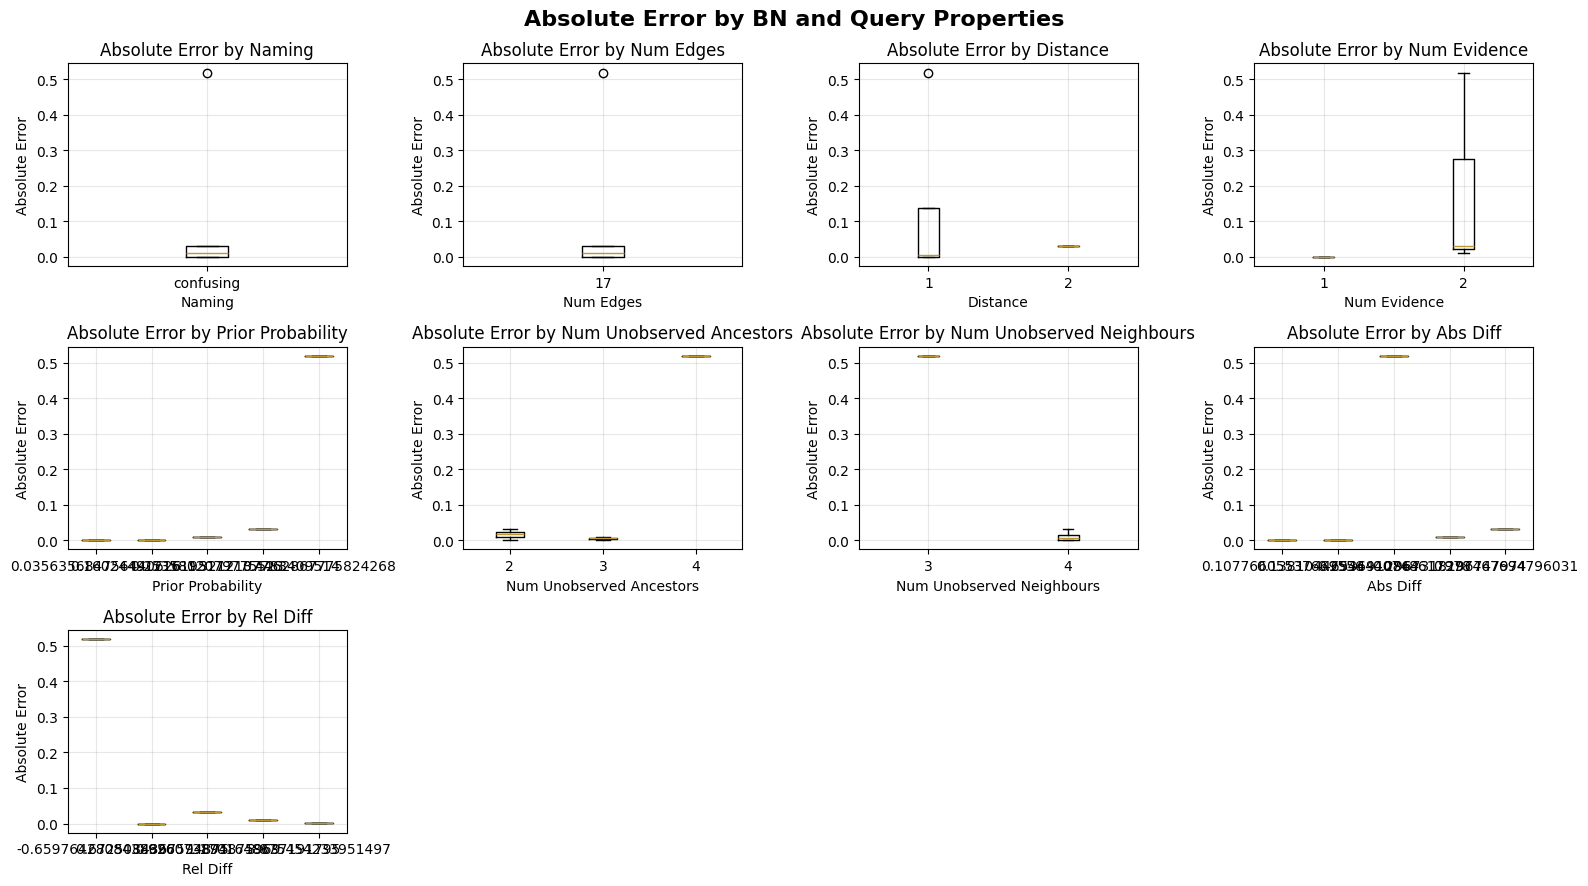


Summary Statistics by Property:

NAMING:
           count      mean       std       min       max
naming                                                  
confusing      5  0.112115  0.227747  0.000011  0.518857

NUM_EDGES:
           count      mean       std       min       max
num_edges                                               
17             5  0.112115  0.227747  0.000011  0.518857

DISTANCE:
          count      mean       std       min       max
distance                                               
1             4  0.132174  0.257829  0.000011  0.518857
2             1  0.031881       NaN  0.031881  0.031881

NUM_EVIDENCE:
              count      mean       std       min       max
num_evidence                                               
1                 2  0.000076  0.000091  0.000011   0.00014
2                 3  0.186809  0.287777  0.009687  0.518857

PRIOR_PROBABILITY:
                   count      mean  std       min       max
prior_probability                 

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Filter to only successful LLM responses with exact inference results
plot_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()].copy()
plot_df['abs_error'] = abs(plot_df['llm_probability'] - plot_df['probability'])

if len(plot_df) > 0:
    # Identify all BN and query property columns (exclude result columns)
    exclude_cols = {'bn_index', 'query_vars', 'query_states', 'evidence', 'probability', 
                   'llm_probability', 'llm_response', 'abs_error', 'rel_error', 'target_tw', 'n', 'seed', 'variant_index',
                   'alpha', 'determinism', 'arity', 'query_index', 
                   'achieved_tw', 'num_nodes'}
    
    # Get all columns that are BN or query properties
    property_cols = [col for col in full_df.columns if col not in exclude_cols]
    
    # Calculate number of subplots needed
    n_props = len(property_cols)
    n_cols = min(4, n_props)  # Max 4 columns
    n_rows = (n_props + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots for all properties
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Absolute Error by BN and Query Properties', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_props == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create boxplots for each property
    for i, prop in enumerate(property_cols):
        ax = axes[i]
        
        # Get unique values for this property
        unique_vals = sorted(plot_df[prop].unique())
        
        # Create boxplot data
        box_data = []
        labels = []
        
        for val in unique_vals:
            subset = plot_df[plot_df[prop] == val]['abs_error']
            if len(subset) > 0:  # Only include if there's data
                box_data.append(subset.values)
                labels.append(str(val))
        
        if box_data:  # Only plot if we have data
            ax.boxplot(box_data, labels=labels)
            ax.set_title(f'Absolute Error by {prop.replace("_", " ").title()}')
            ax.set_xlabel(prop.replace("_", " ").title())
            ax.set_ylabel('Absolute Error')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if there are many unique values
            if len(labels) > 5:
                ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each property
    print("\nSummary Statistics by Property:")
    print("=" * 50)
    
    for prop in property_cols:
        print(f"\n{prop.upper()}:")
        prop_stats = plot_df.groupby(prop)['abs_error'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(prop_stats.round(6))
        
else:
    print("No successful LLM responses with exact inference results available for plotting.")


In [ ]:
# Compute average distance of each number from 0 to 10 to all others

numbers = list(range(11))  # 0 to 10
dists = []
for x in numbers:
    distances = [abs(x - y)**2 for y in numbers]
    avg_distance = sum(distances) / len(distances)
    print(f"{x}: {avg_distance:.2f}")
    dists.append(avg_distance)

from math import sqrt
sqrt(sum(dists) / len(dists))


0: 35.00
1: 26.00
2: 19.00
3: 14.00
4: 11.00
5: 10.00
6: 11.00
7: 14.00
8: 19.00
9: 26.00
10: 35.00


4.47213595499958